In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import sys
sys.path.append("..")
import plotly.express as px
from src import sp_analisis as sa
from src import sp_visualizacion as sv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ejercicio 3. Análisis de la empresa

In [28]:
df_Orders = pd.read_csv('../data/orders.csv')

In [27]:
#paso las columnas de fecha a tipo fecha 
df_Orders[['order_date','required_date','shipped_date']] = df_Orders[['order_date','required_date','shipped_date']].apply(pd.to_datetime, format='%Y-%m-%d')
df_Orders.sample(2)

,order_id,customer_id,ship_via,order_date,required_date,shipped_date,Year,Month
226,10474,PERIC,2,1997-03-13,1997-04-10,1997-03-21,1997,3
742,10990,ERNSH,3,1998-04-01,1998-05-13,1998-04-07,1998,4


In [4]:
df_Customers = pd.read_csv('../data/customers.csv')

In [5]:
# tablas de pedidos y clientes
df_customers_orders = pd.merge(df_Customers,
                               df_Orders,
                               how="left",
                               on="customer_id")

In [82]:
# creacion tabla de productos, proveedores y detalles de los pedidos
query ='''SELECT p.product_id,
                      p.product_name,
                      p.unit_price AS "unit_price_product", 
                      p.units_in_stock, 
                      p.units_on_order, 
                      p.discontinued, 
                      s.supplier_id ,
                      s.company_name AS "company_supplier", 
                      s.city, 
                      s.country,
                      od.order_id, 
                      od.unit_price AS "unit_price_order", 
                      od.quantity, 
                      od.discount
FROM products AS p
FULL JOIN suppliers AS s
ON p.supplier_id = s.supplier_id
FULL JOIN order_details AS od
ON od.product_id = p.product_id -- Realizo dos FULL JOIN ya que me interesan tanto los registros que coinciden como los que no.
'''
df_ProductsDT_Suppliers = sa.pasos_querys(query)
df_ProductsDT_Suppliers.sample(2)

,product_id,product_name,unit_price_product,units_in_stock,units_on_order,discontinued,supplier_id,company_supplier,city,country,order_id,unit_price_order,quantity,discount
891,65,Louisiana Fiery Hot Pepper Sauce,21.05,76,0,0,2,New Orleans Cajun Delights,New Orleans,USA,10580,21.05,30,0.05
232,31,Gorgonzola Telino,12.50,0,70,0,14,Formaggi Fortini s.r.l.,Ravenna,Italy,10335,10.00,25,0.20


----
- #### Haz un estudio de la evolución de los pedidos realizados a lo largo del tiempo. Para ello primero realiza la query necesaria para obtener los meses, años y pedidos durante cada mes. A continuación crea una línea temporal para ver dicha evolución

In [9]:
#primero obtengo los meses y años necesarios para poder calcular los pedidos durante cada mes. 
df_Orders['Year'] = df_Orders['order_date'].dt.year
df_Orders['Month'] = df_Orders['order_date'].dt.month
grouped = df_Orders.groupby(["Year","Month"]).size().reset_index(name='order_count').sort_values(by=['Year', 'Month'])
grouped['Date'] = pd.to_datetime(grouped[['Year', 'Month']].assign(Day=1))
grouped

,Year,Month,order_count,Date
0,1996,7,22,1996-07-01
1,1996,8,25,1996-08-01
2,1996,9,23,1996-09-01
3,1996,10,26,1996-10-01
4,1996,11,25,1996-11-01
5,1996,12,31,1996-12-01
6,1997,1,33,1997-01-01
7,1997,2,29,1997-02-01
8,1997,3,30,1997-03-01
9,1997,4,31,1997-04-01


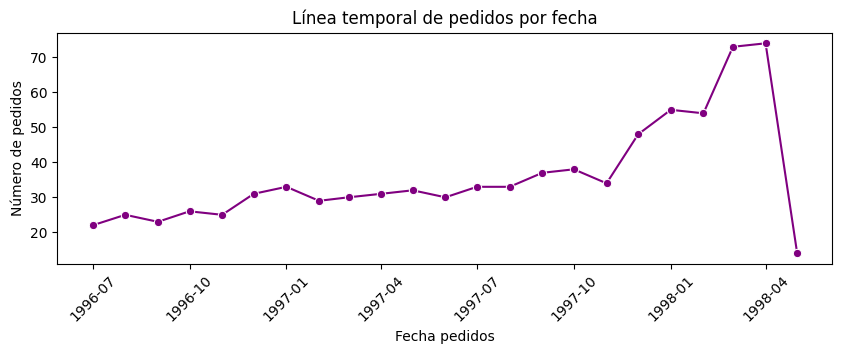

In [10]:
sv.linea_temporal(grouped, 'Date', 'order_count')

----
- #### Investiga cuáles son los países donde tenemos más ventas. No es necesario realizar una query para obtener el DataFrame. Estudia la distribución de pedidos por continente . Realiza la visualización que creas más conveniente.

In [83]:
df_customers_orders['country'].value_counts()

country
Germany        122
USA            122
Brazil          83
France          78
UK              56
Venezuela       46
Austria         40
Sweden          37
Canada          30
Mexico          28
Italy           28
Spain           24
Finland         22
Ireland         19
Belgium         19
Switzerland     18
Denmark         18
Argentina       16
Portugal        13
Poland           7
Norway           6
Name: count, dtype: int64

In [84]:
continentes = {'Europe': ['Austria','Germany','Ireland','Italy','Norway','Switzerland','UK','Belgium','Poland','Denmark','Portugal','Finland','Spain','France','Sweden'],'America': ['Argentina','Brazil','Canada','Mexico','USA','Venezuela'] }

def get_continent(pais):
  for continente, paises in continentes.items():
     if pais in paises:
       return continente

In [13]:
df_customers_orders['continent'] = df_customers_orders['country'].apply(get_continent)
df_customers_orders.sample(2)

,customer_id,company_name,city,country,order_id,ship_via,order_date,required_date,shipped_date,continent
389,LEHMS,Lehmanns Marktstand,Frankfurt a.M.,Germany,10522.0,1.0,1997-04-30,1997-05-28,1997-05-06,Europe
64,BLONP,Blondesddsl père et fils,Strasbourg,France,10679.0,3.0,1997-09-23,1997-10-21,1997-09-30,Europe


In [20]:
ventas_continent= df_customers_orders['continent'].value_counts()
total_ventas = ventas_continent.sum()
porcent_0 = (ventas_continent.values[0]/total_ventas)*100
porcent_1 = (ventas_continent.values[1]/total_ventas)*100
print(f'El continente {ventas_continent.index[0]} tiene {ventas_continent.values[0]} con un porcentaje {porcent_0}')
print(f'El continente {ventas_continent.index[1]} tiene {ventas_continent.values[1]} con un porcentaje {porcent_1}')

El continente Europe tiene 507 con un porcentaje 60.9375
El continente America tiene 325 con un porcentaje 39.0625


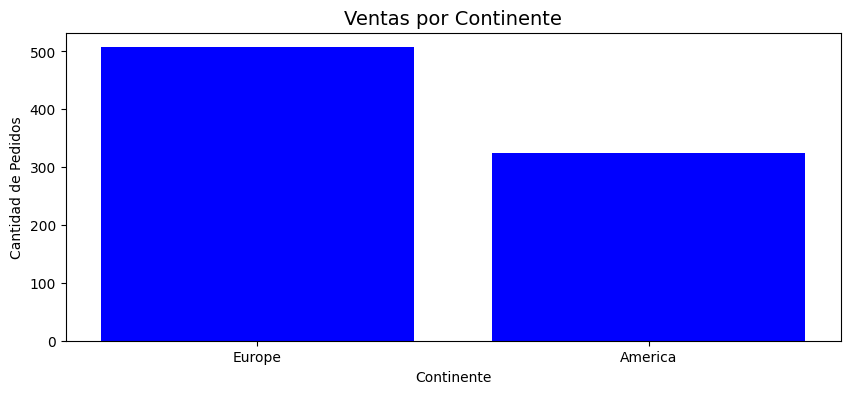

In [ ]:
sv.barras(ventas_continent)

---
- #### Sabemos que algunos pedidos han llegado con retraso, además hay pedidos que no ha sido registrada su llegada. Investiga si la compañía de transporte está relacionada con ello o no. Realiza un boxplot para ver la diferencia de rango intercuartílico.

In [85]:
df_Shippers = pd.read_csv('../data/shippers.csv')

In [90]:
#calculo un columna para saber si el pedido ha sido retrasado o no se ha enviado
df_customers_orders['delays'] = (df_customers_orders['shipped_date'] - df_customers_orders['required_date']).dt.days

In [91]:
df = df_customers_orders.merge(df_Shippers,
                               how='inner',
                               left_on='ship_via',
                               right_on='shipper_id'
                               )
df.rename(columns={'company_name_y': 'shipper_company'}, inplace=True)
df

,customer_id,company_name_x,city,country,order_id,ship_via,order_date,required_date,shipped_date,continent,days_to_ship,delays,shipper_id,shipper_company
0,ALFKI,Alfreds Futterkiste,Berlin,Germany,10643.0,1.0,1997-08-25,1997-09-22,1997-09-02,Europe,8.0,-20.0,1,Speedy Express
1,ALFKI,Alfreds Futterkiste,Berlin,Germany,10692.0,2.0,1997-10-03,1997-10-31,1997-10-13,Europe,10.0,-18.0,2,United Package
2,ALFKI,Alfreds Futterkiste,Berlin,Germany,10702.0,1.0,1997-10-13,1997-11-24,1997-10-21,Europe,8.0,-34.0,1,Speedy Express
3,ALFKI,Alfreds Futterkiste,Berlin,Germany,10835.0,3.0,1998-01-15,1998-02-12,1998-01-21,Europe,6.0,-22.0,3,Federal Shipping
4,ALFKI,Alfreds Futterkiste,Berlin,Germany,10952.0,1.0,1998-03-16,1998-04-27,1998-03-24,Europe,8.0,-34.0,1,Speedy Express
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,WOLZA,Wolski Zajazd,Warszawa,Poland,10792.0,3.0,1997-12-23,1998-01-20,1997-12-31,Europe,8.0,-20.0,3,Federal Shipping
826,WOLZA,Wolski Zajazd,Warszawa,Poland,10870.0,3.0,1998-02-04,1998-03-04,1998-02-13,Europe,9.0,-19.0,3,Federal Shipping
827,WOLZA,Wolski Zajazd,Warszawa,Poland,10906.0,3.0,1998-02-25,1998-03-11,1998-03-03,Europe,6.0,-8.0,3,Federal Shipping
828,WOLZA,Wolski Zajazd,Warszawa,Poland,10998.0,2.0,1998-04-03,1998-04-17,1998-04-17,Europe,14.0,0.0,2,United Package


In [99]:
fig = px.box(df, y = 'delays', color = 'shipper_company')
fig.show()

In [108]:
company_list = df['shipper_company'].unique().tolist()
for company in company_list:
    df_company = df[df['shipper_company'] == company]
    null_percent = df_company['delays'].isnull().sum()/ df_company.shape[0] *100
    print(f"La compañía {company} no ha registrado un {round(null_percent,2)}% de los viajes.")

La compañía Speedy Express no ha registrado un 1.61% de los viajes.
La compañía United Package no ha registrado un 3.37% de los viajes.
La compañía Federal Shipping no ha registrado un 2.35% de los viajes.


      En base a esto podemos observar que todas las compañias han tenido retrasos, United Pckage ha tenido un poco mas pero no significativamente

----
- #### Hay bastante diferencia entre el precio pagado en cada pedido. Averigüa la distribución media del precio del pedido por país de procedencia del cliente. Realiza la visualización que creas más conveniente para sacar conclusiones

In [121]:
query = ''' SELECT order_id,
            SUM(unit_price*quantity-discount*unit_price*quantity) AS "total_order"
            FROM order_details
            GROUP BY order_id'''
df_sum_orders = sa.pasos_querys(query)
df_sum_orders

,order_id,total_order
0,11038,732.6000
1,10782,12.5000
2,10725,287.8000
3,10423,1020.0000
4,10518,4150.0500
...,...,...
825,10707,1641.0000
826,10826,730.0000
827,10371,72.9600
828,10575,2147.4000


In [125]:
total_orders = df_sum_orders.merge(df_customers_orders, 
                                   how='inner',
                                   left_on='order_id',
                                   right_on='order_id'
                                   )
total_country = total_orders.groupby('country')['total_order'].mean().reset_index().sort_values(by='total_order', ascending=False)
total_country

,country,total_order
1,Austria,3200.0960
9,Ireland,2630.5213
19,USA,2012.9886
8,Germany,1887.5790
5,Denmark,1814.5012
2,Belgium,1780.2555
17,Switzerland,1760.7033
4,Canada,1673.2097
16,Sweden,1472.8416
3,Brazil,1288.2624


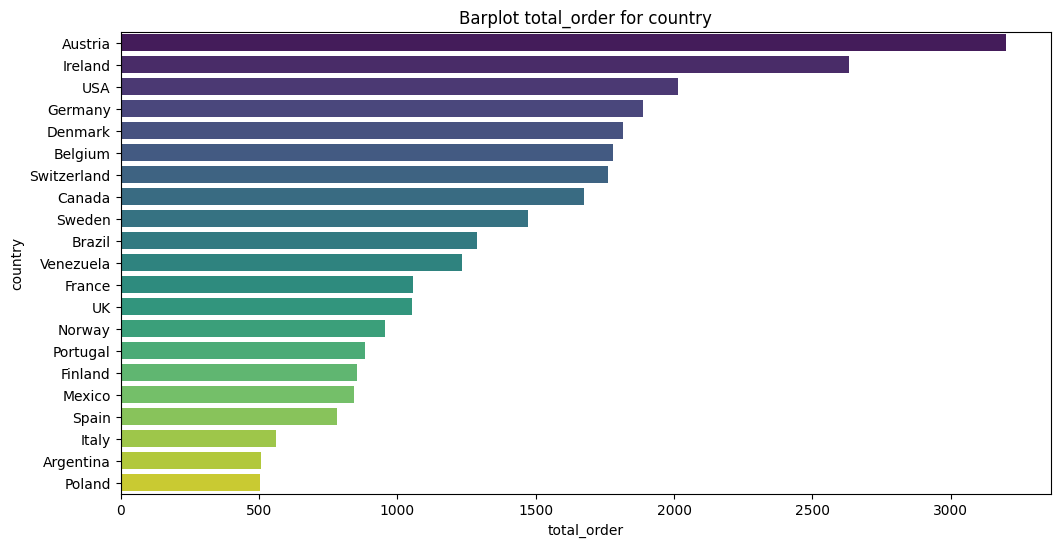

In [126]:
sv.barplot(total_country,'total_order', 'country',"viridis")

        Como se puede ver en la gráfica el precio medio en Francia es mucho más elevado que el resto

---
- #### Investiga si existen clientes que no hayan pedido nunca. ¿Qué porcentaje de clientes no tienen pedidos registrados?

In [76]:
df_nulos = df[df["order_id"].isnull()]
df_nulos

,customer_id,company_name_x,city,country,order_id,ship_via,order_date,required_date,shipped_date,continent,days_to_ship,delays,shipper_id,shipper_company
188,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Madrid,Spain,NaN,NaN,NaT,NaT,NaT,Europe,NaN,True,NaN,NaN
501,PARIS,Paris spécialités,Paris,France,NaN,NaN,NaT,NaT,NaT,Europe,NaN,True,NaN,NaN


In [ ]:
order_nulo= round(df["order_id"].isnull().sum()/df["order_id"].shape[0]*100,2)
print(f'El porcentaje de clientes que no han pedido es del {order_nulo} %')

El porcentaje de clientes que no han pedido es del 0.24 %


----
- #### Estudia los productos más demandados e investiga cuáles corre prisa hacer reestock (Los que quedan 20 o menos y no hay unidades pedidas). Realiza la visualización que creas más conveniente para sacar conclusiones

In [145]:
df_ProductsDT_Suppliers.columns

Index(['product_id', 'product_name', 'unit_price_product', 'units_in_stock',
       'units_on_order', 'discontinued', 'supplier_id', 'company_supplier',
       'city', 'country', 'order_id', 'unit_price_order', 'quantity',
       'discount', 'total_order'],
      dtype='object')

In [142]:
df_orders_counts=df_ProductsDT_Suppliers.groupby("product_name")['order_id'].count().reset_index()
df_summary= df_orders_counts.sort_values(by='order_id',ascending=False)
df_summary

,product_name,order_id
51,Raclette Courdavault,54
18,Gorgonzola Telino,51
21,Guaraná Fantástica,51
3,Camembert Pierrot,51
17,Gnocchi di nonna Alice,50
...,...,...
35,Louisiana Hot Spiced Okra,8
20,Gravad lax,6
16,Genen Shouyu,6
10,Chocolade,6


In [147]:
menor_20 = df_ProductsDT_Suppliers["units_in_stock"] <= 20
sin_pedido = df_ProductsDT_Suppliers["units_on_order"] == 0
no_disc = df_ProductsDT_Suppliers['discontinued'] == 0

df_restock = df_ProductsDT_Suppliers[menor_20 & sin_pedido & no_disc]['product_name'].reset_index()

df_restock

,index,product_name
0,2,Mozzarella di Giovanni
1,4,Manjimup Dried Apples
2,6,Manjimup Dried Apples
3,13,Camembert Pierrot
4,36,Tarte au sucre
...,...,...
337,2101,Nord-Ost Matjeshering
338,2115,Uncle Bob's Organic Dried Pears
339,2134,Uncle Bob's Organic Dried Pears
340,2135,Northwoods Cranberry Sauce


In [150]:
print(f"Necesitamos hacer restock de todos estos productos pues quedan menos de 20 unidades y no hay unidades pedidas: \n", df_restock['product_name'].unique()) 

Necesitamos hacer restock de todos estos productos pues quedan menos de 20 unidades y no hay unidades pedidas: 
 ['Mozzarella di Giovanni' 'Manjimup Dried Apples' 'Camembert Pierrot'
 'Tarte au sucre' 'Steeleye Stout' "Uncle Bob's Organic Dried Pears"
 'Nord-Ost Matjeshering' 'Côte de Blaye' 'Gumbär Gummibärchen'
 'Northwoods Cranberry Sauce']


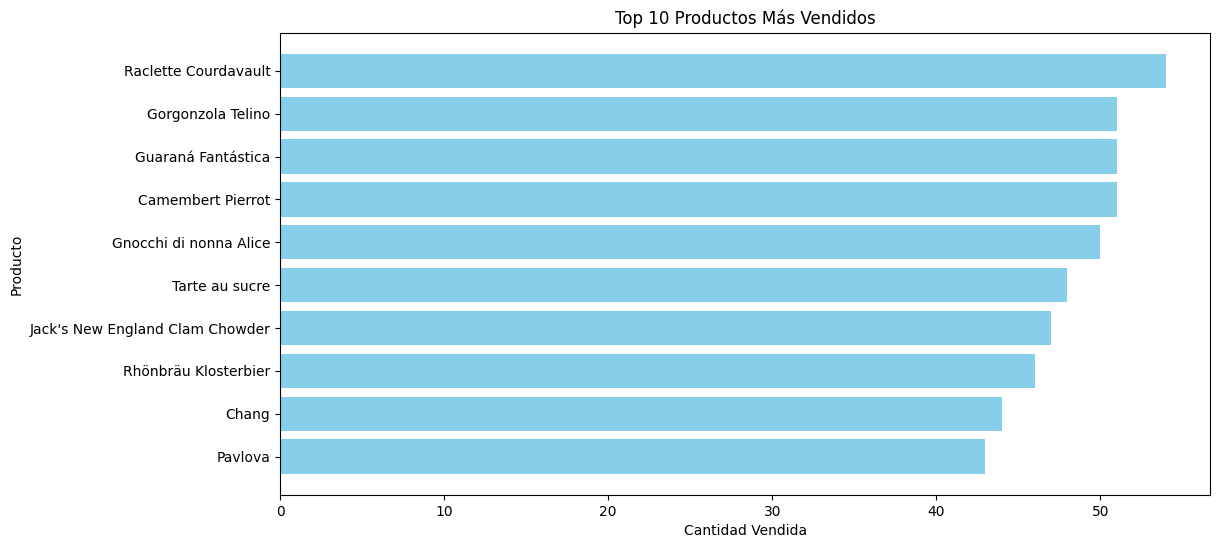

In [152]:
top_10= df_summary.head(10)
sv.barh(top_10["product_name"], top_10['order_id'],'skyblue')

In [ ]:
print(f'Tenemos {df_restock["product_name"].count()} productos que necesitan reabastecerse y como podemos ver en los graficos son bastante demandados por lo que hay que hacerlo pronto')

Tenemos 15 productos que necesitan reabastecerse y como podemos ver en los graficos son bastante demandados por lo que hay que hacerlo pronto


In [153]:
df_ProductsDT_Suppliers.to_csv('../data/details_prod_supl.csv', index=False)
df_customers_orders.to_csv('../data/customers_orders.csv', index=False)